# SpoilerShield: NLP Text Classification Project

**Author:** Scott Stearns  
**Notebook:** Kaggle EDA & Modeling Workflow

---

## Table of Contents
1. [Details of the Dataset](#details)
2. [Exploratory Data Analysis](#eda)
3. [Model Training and Hyperparameter Search](#training)
4. [Model Evaluation](#evaluation)

---

This notebook demonstrates a professional, modular workflow for text classification.

In [39]:
# Imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json

In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Mount drive for Google Colab - set to False for other environments
if True:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def detect_environment():
    if (os.path.exists("/kaggle/input") and
        len(os.listdir("/kaggle/input")) > 0):
        return "kaggle"
    elif os.path.ismount('/content/drive'):
        return "colab"
    else:
        return "local"

In [5]:
env = detect_environment()
print(f"Detected environment: {env}")

Detected environment: colab


In [6]:
# Set up paths for Kaggle, Google Colab or local environment
def set_paths(env):
    if env == "kaggle":
        src_path = '/kaggle/input/spoiler-shield-code/spoiler_shield_code/implementation/src'
        data_path = '/kaggle/input/spoiler-shield-code/spoiler_shield_code/implementation/src/data'
    elif env == 'colab':
        src_path = '/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src'
        data_path = '/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/data'
    else:
        # Local: adjust as needed
        src_path = os.path.abspath(os.path.join(os.getcwd(), '../../implementation/src'))
    if src_path not in sys.path:
        sys.path.insert(0, src_path)
    return src_path, data_path

src_path, data_path  = set_paths(env)
os.chdir(src_path)

In [7]:
os.listdir(os.getcwd())

['features',
 'visualization',
 'data',
 'utils',
 'evaluation',
 'models',
 'eda',
 '01_data_eda.py']

In [8]:
os.path.dirname(os.path.abspath("__file__"))

'/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src'

In [9]:
# Import utilities and class definitions
from eda.data_loader import DataLoader
from eda.text_analyzer import TextAnalyzer
from eda.visualization import TextVisualizer
from eda.transformer_processor import TransformerTextProcessor
from utils.env_config import EnvConfig

In [10]:
# Get configuration to make handling mulitple environments easier for the
# remainder of the project
config = EnvConfig()
print(f"Environment: {config.env}")
print(f"Data directory: {config.data_dir}")
print(f"Output directory: {config.output_dir}")

Environment: colab
Data directory: /content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/data
Output directory: /content/drive/MyDrive/IK Course Materials/SpoilerShield/outputs


In [11]:
# Load the training data sets and confirm the dataframes are uploaded.
print("="*60)
print("LOADING DATA")
print("="*60)

data_loader = DataLoader(
    config.get_data_path('train_reviews.json'),
    config.get_data_path('IMDB_movie_details.json')
    )

df_reviews = data_loader.load_imdb_movie_reviews()
df_details = data_loader.load_imdb_movie_details()

print(f"✅ Loaded {len(df_reviews)} reviews")
print(f"✅ Loaded {len(df_details)} movie details")


LOADING DATA
✅ Loaded 79999 reviews
✅ Loaded 1572 movie details


In [12]:
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,21 August 1999,tt0129387,ur0286745,False,"While Stiller, Diaz, and to some degree Dillon...",3,For those who think the 3 Stooges are funny.
1,7 June 2002,tt0285742,ur1785392,False,I realize that this film has received seriousl...,8,"flawed, but all the better for it"
2,10 May 2015,tt0362227,ur23538961,True,"Sometimes you say for some role: ""this role co...",7,"Great performances, interesting topic"
3,2 September 1998,tt0054215,ur0068788,False,One of the all-time greats. To say more is un...,10,Classic
4,8 October 2003,tt0129167,ur2049571,False,"Even years after its release, I still find The...",10,Wonderful for kids and adults


In [13]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


---

## 1. <a id='details'></a>Details of the Dataset

In this section, we provide a comprehensive overview of the dataset, including its size, features, target variables, and data types.


In [14]:
# Display dataset specs
print('Reviews shape:', df_reviews.shape)
print('Details shape:', df_details.shape)
print('Review columns:', df_reviews.columns.tolist())
print('Details columns:', df_details.columns.tolist())
print('Review dtypes:')
print(df_reviews.dtypes)
print('Details dtypes:')
print(df_details.dtypes)
print('Sample reviews:')
display(df_reviews.head())
print('Sample details:')
display(df_details.head())
print('Missing values in reviews:')
print(df_reviews.isnull().sum())
print('Missing values in details:')
print(df_details.isnull().sum())

Reviews shape: (79999, 7)
Details shape: (1572, 7)
Review columns: ['review_date', 'movie_id', 'user_id', 'is_spoiler', 'review_text', 'rating', 'review_summary']
Details columns: ['movie_id', 'plot_summary', 'duration', 'genre', 'rating', 'release_date', 'plot_synopsis']
Review dtypes:
review_date       object
movie_id          object
user_id           object
is_spoiler          bool
review_text       object
rating             int64
review_summary    object
dtype: object
Details dtypes:
movie_id          object
plot_summary      object
duration          object
genre             object
rating           float64
release_date      object
plot_synopsis     object
dtype: object
Sample reviews:


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,21 August 1999,tt0129387,ur0286745,False,"While Stiller, Diaz, and to some degree Dillon...",3,For those who think the 3 Stooges are funny.
1,7 June 2002,tt0285742,ur1785392,False,I realize that this film has received seriousl...,8,"flawed, but all the better for it"
2,10 May 2015,tt0362227,ur23538961,True,"Sometimes you say for some role: ""this role co...",7,"Great performances, interesting topic"
3,2 September 1998,tt0054215,ur0068788,False,One of the all-time greats. To say more is un...,10,Classic
4,8 October 2003,tt0129167,ur2049571,False,"Even years after its release, I still find The...",10,Wonderful for kids and adults


Sample details:


,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


Missing values in reviews:
review_date       0
movie_id          0
user_id           0
is_spoiler        0
review_text       0
rating            0
review_summary    0
dtype: int64
Missing values in details:
movie_id         0
plot_summary     0
duration         0
genre            0
rating           0
release_date     0
plot_synopsis    0
dtype: int64


In [15]:
# Clean data - drop records if no data in review_text or is_spoiler
initial_count = len(df_reviews)
df_reviews = df_reviews.dropna(subset=['review_text', 'is_spoiler'])
final_count = len(df_reviews)

if initial_count != final_count:
    print(f"⚠️  Removed {initial_count - final_count} rows with missing values")

print(f"✅ Final dataset size: {final_count} reviews")

✅ Final dataset size: 79999 reviews


In [16]:
#TODO - repair warnings for deprecated use of keys for position. To access a
# value by position, use `ser.iloc[pos]`

# Cell 3: Dataset Details & Specifications
print("=" * 60)
print("2. DATASET DETAILS & SPECIFICATIONS")
print("=" * 60)

# Basic statistics
total_reviews = len(df_reviews)
total_movies = len(df_details)

print(f"📊 Total Reviews: {total_reviews:,}")
print(f"📊 Total Movies: {total_movies:,}")

# Class distribution
class_distribution = df_reviews['is_spoiler'].value_counts()
class_percentages = df_reviews['is_spoiler'].value_counts(normalize=True) * 100

print(f"\n📈 Class Distribution:")
print(f"  Non-spoiler (0): {class_distribution[0]:,} ({class_percentages[0]:.1f}%)")
print(f"  Spoiler (1): {class_distribution[1]:,} ({class_percentages[1]:.1f}%)")

# Imbalance ratio
imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"  Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Text length statistics
text_lengths = df_reviews['review_text'].str.len()

print(f"\n📝 Text Statistics (characters):")
print(f"  Average length: {text_lengths.mean():.0f}")
print(f"  Median length: {text_lengths.median():.0f}")
print(f"  Min length: {text_lengths.min()}")
print(f"  Max length: {text_lengths.max()}")
print(f"  Std deviation: {text_lengths.std():.0f}")

# Data types
print(f"\n🔍 Data Types:")
print(df_reviews.dtypes)

# Sample data
print(f"\n📄 Sample Reviews:")
for i in range(min(3, len(df_reviews))):
    review = df_reviews.iloc[i]
    print(f"  Example {i+1} (Spoiler: {review['is_spoiler']}):")
    print(f"    {review['review_text'][:200]}...")
    print()

# Store dataset details for later use
dataset_details = {
    'total_reviews': total_reviews,
    'total_movies': total_movies,
    'class_distribution': class_distribution.to_dict(),
    'class_percentages': class_percentages.to_dict(),
    'imbalance_ratio': imbalance_ratio,
    'text_length_stats': {
        'mean': text_lengths.mean(),
        'median': text_lengths.median(),
        'min': text_lengths.min(),
        'max': text_lengths.max(),
        'std': text_lengths.std()
    }
}

2. DATASET DETAILS & SPECIFICATIONS
📊 Total Reviews: 79,999
📊 Total Movies: 1,572

📈 Class Distribution:
  Non-spoiler (0): 58,961 (73.7%)
  Spoiler (1): 21,038 (26.3%)
  Imbalance Ratio: 2.80:1

📝 Text Statistics (characters):
  Average length: 1457
  Median length: 1052
  Min length: 18
  Max length: 14963
  Std deviation: 1123

🔍 Data Types:
review_date       object
movie_id          object
user_id           object
is_spoiler          bool
review_text       object
rating             int64
review_summary    object
dtype: object

📄 Sample Reviews:
  Example 1 (Spoiler: False):
    While Stiller, Diaz, and to some degree Dillon made this film bearable, it mostly stunk. It consisted mostly of cruel humor, cartoon acting, and pointless ruinous plot twists. Love stories don't work ...

  Example 2 (Spoiler: False):
    I realize that this film has received seriously divergent reviews from different parties, but I, for one, thought that it was excellent. Flawed, yes, but anything that seem

/tmp/ipython-input-16-516712644.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  Non-spoiler (0): {class_distribution[0]:,} ({class_percentages[0]:.1f}%)")
/tmp/ipython-input-16-516712644.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  Spoiler (1): {class_distribution[1]:,} ({class_percentages[1]:.1f}%)")


---

## 2. <a id='eda'></a>Exploratory Data Analysis

Statistical analyses and visual examinations to uncover patterns, anomalies, and relationships within the dataset. Document findings to inform subsequent modeling decisions.


In [17]:
# Initialize the analyzer and visualizer with the data

print("=" * 60)
print("EXPLORATORY DATA ANALYSIS - SETUP")
print("=" * 60)

analyzer = TextAnalyzer(
    texts=df_reviews['review_text'],
    labels=df_reviews['is_spoiler']
)
visualizer = TextVisualizer(
    texts=df_reviews['review_text'],
    labels=df_reviews['is_spoiler']
)

print("✅ Text analyzer and visualizer initialized")

EXPLORATORY DATA ANALYSIS - SETUP


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Text analyzer and visualizer initialized


In [18]:
# Text Statistics
print("📊 Text Statistics:")
text_stats = analyzer.get_text_statistics()
for key, value in text_stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

# Class distribution analysis
print("\n🎯 Class Distribution Analysis:")
class_counts, class_percentages, imbalance_ratio = analyzer.analyze_class_distribution()
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")
print("  Class counts:")
for class_val, count in class_counts.items():
    print(f"    {class_val}: {count}")

📊 Text Statistics:
  total_documents: 79999
  avg_length: 296.03
  min_length: 2
  max_length: 2961
  vocabulary_size: 298527

🎯 Class Distribution Analysis:
  Imbalance ratio: 2.80
  Class counts:
    False: 58961
    True: 21038


In [19]:
# Word Frequency Analysis
print("📝 Word Frequency Analysis:")
word_freq = analyzer.analyze_word_frequency(n_top=20, remove_stopwords=True)
print("  Top 20 most frequent words:")
for word, freq in word_freq.head(10).items():
    print(f"    {word}: {freq}")

# Display full word frequency
word_freq.head(20)

📝 Word Frequency Analysis:
  Top 20 most frequent words:
    I: 307337
    movie: 192398
    film: 144492
    The: 141164
    n't: 125083
    one: 82000
    like: 71070
    It: 64102
    good: 55842
    story: 50114


,0
I,307337
movie,192398
film,144492
The,141164
n't,125083
one,82000
like,71070
It,64102
good,55842
story,50114


📏 Document Length Analysis:
  Average document length: 296.0 words
  Median document length: 216.0 words
  Min document length: 2 words
  Max document length: 2961 words


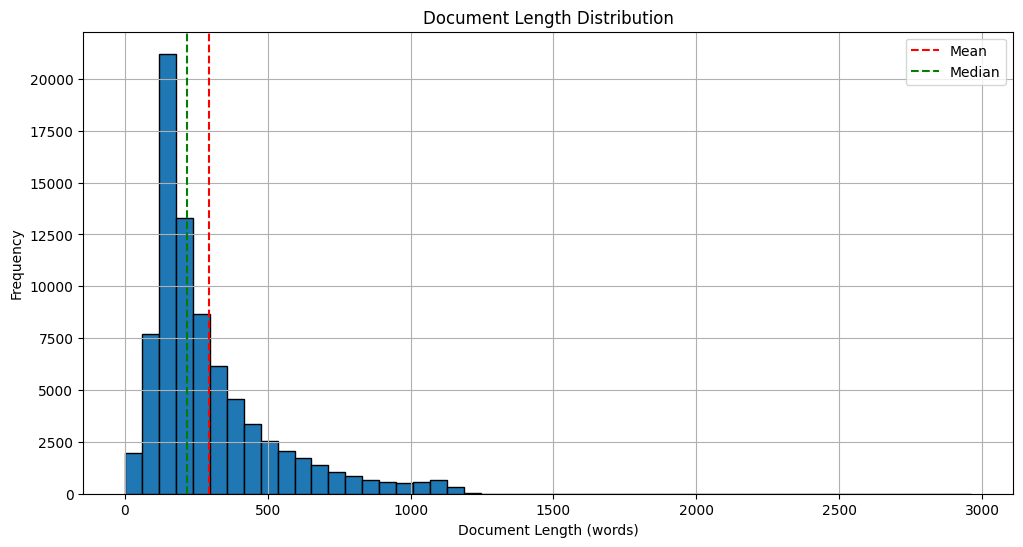

In [26]:
# Document Length Analysis
print("📏 Document Length Analysis:")
doc_lengths = analyzer.get_document_lengths()
print(f"  Average document length: {np.mean(doc_lengths):.1f} words")
print(f"  Median document length: {np.median(doc_lengths):.1f} words")
print(f"  Min document length: {np.min(doc_lengths)} words")
print(f"  Max document length: {np.max(doc_lengths)} words")

# Document length distribution
visualizer.plot_document_length_distribution()

🎨 Word Frequency Visualizations


/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/eda/visualization.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq.index, y=word_freq.values, palette='viridis')


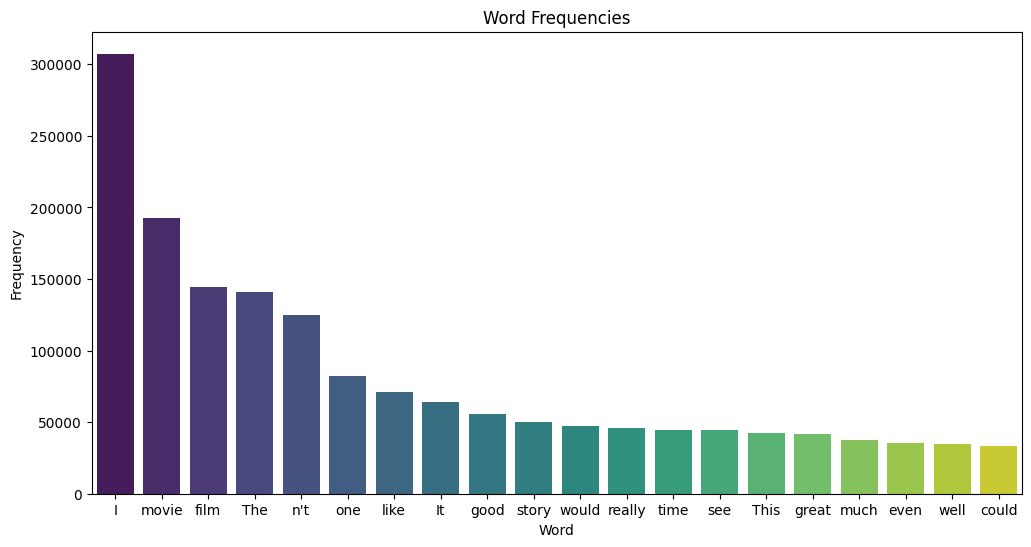

In [27]:
# Visualizations - Word Frequencies
print("🎨 Word Frequency Visualizations")

# Word frequency plot
visualizer.plot_word_frequencies(n_top=20, remove_stopwords=True)

🎨 Class Distribution Visualization


/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/eda/visualization.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
/content/drive/MyDrive/IK Course Materials/SpoilerShield/implementation/src/eda/visualization.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_percentages.index, y=class_percentages.values, palette='viridis')


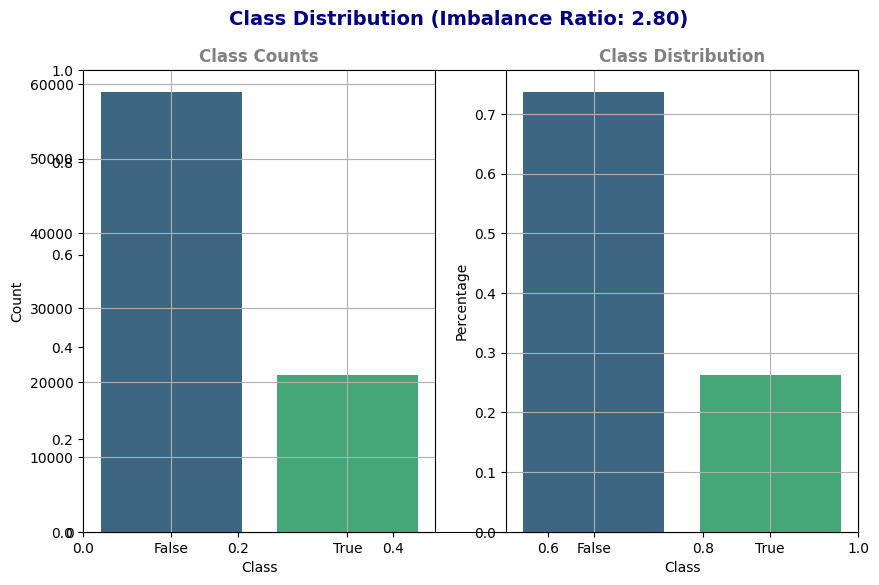

In [28]:
# Visualizations - Class Distribution
print("🎨 Class Distribution Visualization")

# Class distribution plot
visualizer.plot_class_distribution()

🎨 Word Cloud Visualizations


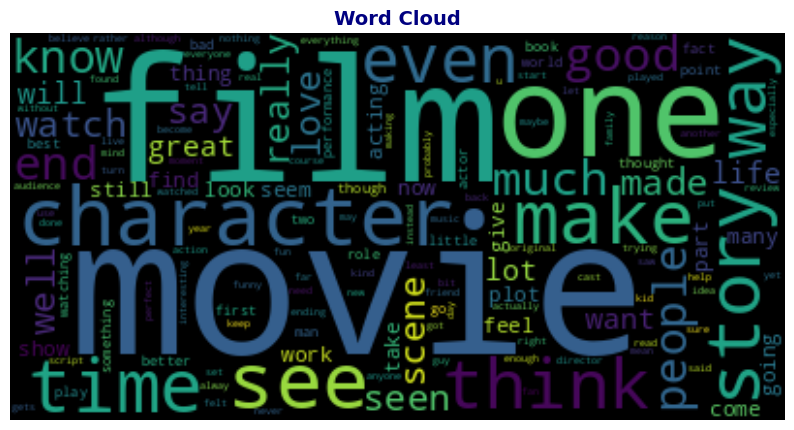

In [29]:
# Visualizations - Word Clouds
print("🎨 Word Cloud Visualizations")

# Word cloud for all data
visualizer.plot_wordcloud()

🎨 Word Clouds by Class

Word cloud for class False:


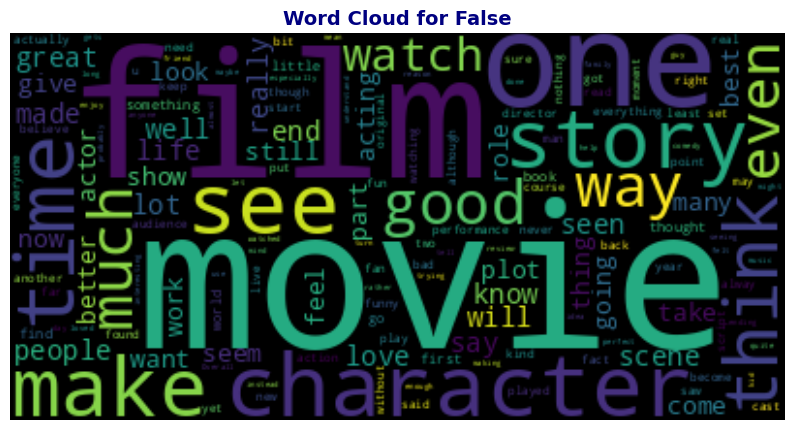


Word cloud for class True:


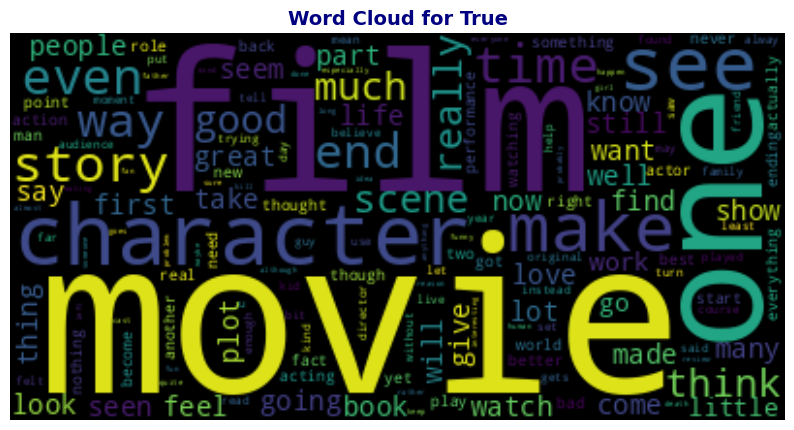

In [30]:
# Visualizations - Word Clouds by Class
print("🎨 Word Clouds by Class")

# Word clouds by class
for label in df_reviews['is_spoiler'].unique():
    print(f"\nWord cloud for class {label}:")
    visualizer.plot_wordcloud(class_label=label)

🎨 Word Frequencies by Class


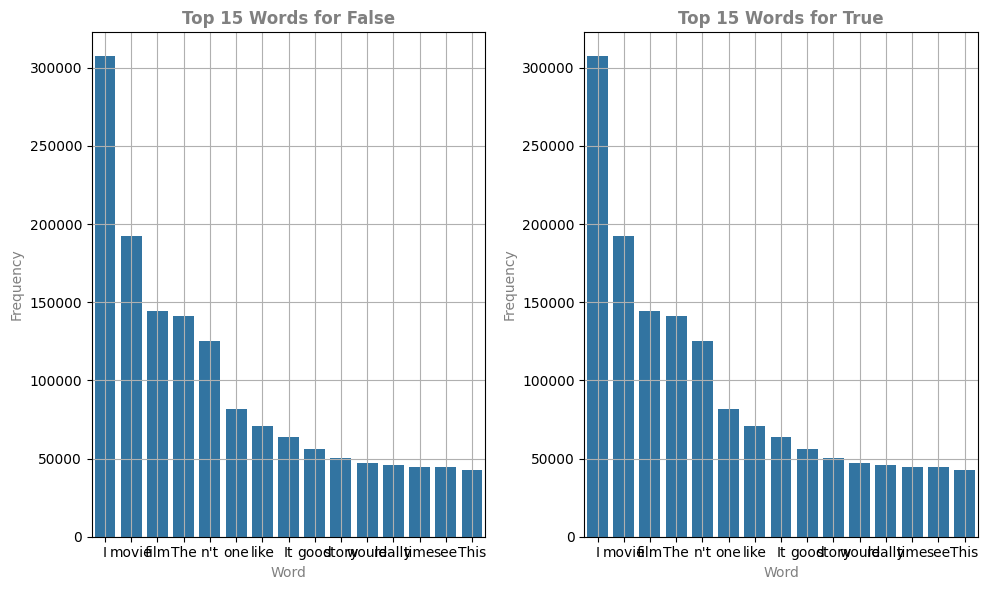

✅ EDA Visualizations Complete!


In [31]:
# Visualizations - Class Word Frequencies
print("🎨 Word Frequencies by Class")

# Class word frequencies
visualizer.plot_class_word_frequencies(n_top=15, remove_stopwords=True)

print("✅ EDA Visualizations Complete!")

---

## Save data for model building and evaluation steps


In [32]:
# Transformer Data Preparation
print("=" * 60)
print("TRANSFORMER DATA PREPARATION")
print("=" * 60)

# Configuration
model_name = 'allenai/longformer-base-4096' #'bert-base-uncased' for shorter sequences
max_length = 1024

# Initialize processor
processor = TransformerTextProcessor(
    model_name=model_name,
    max_length=max_length
)

print(f"🤖 Using model: {model_name}")
print(f"📏 Max sequence length: {max_length}")

# Analyze sequence lengths
print("\n📊 Analyzing sequence lengths...")
processor.print_sequence_analysis(df_reviews['review_text'])

TRANSFORMER DATA PREPARATION


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

🤖 Using model: allenai/longformer-base-4096
📏 Max sequence length: 1024

📊 Analyzing sequence lengths...
SEQUENCE LENGTH ANALYSIS
Total texts: 79999
Average token length: 322.6
Max token length: 3255
Current model limit: 1024
Texts exceeding limit: 2256 (2.8%)

⚠️  WARNING: 2256 texts exceed the current model's limit!
Max length needed: 3255 tokens

RECOMMENDED MODELS:
  • allenai/longformer-base-4096 (max: 4096 tokens)
    Longformer, designed for long documents
  • google/bigbird-roberta-base (max: 4096 tokens)
    BigBird, sparse attention for long sequences
  • allenai/led-base-16384 (max: 16384 tokens)
    LED, extremely long context

EXAMPLES OF LONG TEXTS:
  Text 42: 1264 tokens
    Preview: Everybody remembers the scene. It's the one where he walks along the street, dancing, and singin' in...
  Text 69: 1229 tokens
    Preview: All aspects of this film, "The Passion of the Christ" are excellent. The technical values, shooting ...
  Text 96: 1267 tokens
    Preview: The first th

In [35]:
# Text Encoding
# Get texts and labels
texts = df_reviews['review_text'].tolist()
labels = df_reviews['is_spoiler'].tolist()

print(f"⚙️ Encoding {len(texts)} texts...")

# Encode texts
encoded = processor.encode_texts(
    texts=texts,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

print(f"✅ Encoded shape: {encoded['input_ids'].shape}")
print(f"✅ Keys in encoded output: {list(encoded.keys())}")

# Create labels tensor
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Prepare data dictionary
processed_data = {
    'input_ids': encoded['input_ids'],
    'attention_mask': encoded['attention_mask'],
    'labels': labels_tensor,
    'model_name': model_name,
    'max_length': max_length,
    'num_samples': len(texts)
}

print(f"✅ Data prepared for model training")
print(f"   - Input IDs shape: {processed_data['input_ids'].shape}")
print(f"   - Attention mask shape: {processed_data['attention_mask'].shape}")
print(f"   - Labels shape: {processed_data['labels'].shape}")

⚙️ Encoding 79999 texts...
✅ Encoded shape: torch.Size([79999, 1024])
✅ Keys in encoded output: ['input_ids', 'attention_mask']
✅ Data prepared for model training
   - Input IDs shape: torch.Size([79999, 1024])
   - Attention mask shape: torch.Size([79999, 1024])
   - Labels shape: torch.Size([79999])


In [37]:
# Save Processed Data
print("=" * 60)
print("SAVING PROCESSED DATA")
print("=" * 60)

# Store EDA results
eda_results = {
    'text_statistics': text_stats,
    'class_analysis': {
        'class_counts': class_counts.to_dict(),
        'class_percentages': class_percentages.to_dict(),
        'imbalance_ratio': imbalance_ratio
    },
    'word_frequency': word_freq.to_dict(),
    'document_lengths': {
        'mean': np.mean(doc_lengths),
        'median': np.median(doc_lengths),
        'min': np.min(doc_lengths),
        'max': np.max(doc_lengths),
        'std': np.std(doc_lengths)
    }
}

# Create output directory
output_dir = config.output_dir
output_dir.mkdir(exist_ok=True)

# Save processed data
data_path = output_dir / 'processed_data.pt'
torch.save(processed_data, data_path)
print(f"✅ Saved processed data to: {data_path}")

# Save metadata
metadata = {
    'dataset_details': dataset_details,
    'eda_results': eda_results,
    'processing_timestamp': pd.Timestamp.now().isoformat()
}

metadata_path = output_dir / 'data_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"✅ Saved metadata to: {metadata_path}")

# Save summary
summary = {
    'data_shape': {
        'input_ids': list(processed_data['input_ids'].shape),
        'attention_mask': list(processed_data['attention_mask'].shape),
        'labels': list(processed_data['labels'].shape)
    },
    'model_info': {
        'model_name': processed_data['model_name'],
        'max_length': processed_data['max_length'],
        'num_samples': processed_data['num_samples']
    },
    'class_distribution': metadata['dataset_details']['class_distribution'],
    'files_created': [
        str(data_path),
        str(metadata_path)
    ]
}

summary_path = output_dir / 'processing_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"✅ Saved summary to: {summary_path}")

SAVING PROCESSED DATA
✅ Saved processed data to: /content/drive/MyDrive/IK Course Materials/SpoilerShield/outputs/processed_data.pt
✅ Saved metadata to: /content/drive/MyDrive/IK Course Materials/SpoilerShield/outputs/data_metadata.json
✅ Saved summary to: /content/drive/MyDrive/IK Course Materials/SpoilerShield/outputs/processing_summary.json


In [38]:
# Summary & Next Steps
print("=" * 60)
print("✅ DATA PREPARATION COMPLETE!")
print("=" * 60)

print("\n📊 Summary:")
print(f"  • Processed {processed_data['num_samples']} reviews")
print(f"  • Using model: {processed_data['model_name']}")
print(f"  • Max sequence length: {processed_data['max_length']}")
print(f"  • Class distribution: {metadata['dataset_details']['class_distribution']}")

print("\n📁 Files created:")
for file_path in summary['files_created']:
    print(f"  • {file_path}")

print("\n🔄 Next steps:")
print("1. Review the generated visualizations")
print("2. Check the processed data files")
print("3. Run 02_model_training.py to train models")
print("4. Compare different transformer models")

✅ DATA PREPARATION COMPLETE!

📊 Summary:
  • Processed 79999 reviews
  • Using model: allenai/longformer-base-4096
  • Max sequence length: 1024
  • Class distribution: {False: 58961, True: 21038}

📁 Files created:
  • /content/drive/MyDrive/IK Course Materials/SpoilerShield/outputs/processed_data.pt
  • /content/drive/MyDrive/IK Course Materials/SpoilerShield/outputs/data_metadata.json

🔄 Next steps:
1. Review the generated visualizations
2. Check the processed data files
3. Run 02_model_training.py to train models
4. Compare different transformer models


---

## 3. <a id='training'></a>Model Training and Hyperparameter Search

Selection and training of machine learning models on the processed dataset. Employ hyperparameter optimization techniques to fine-tune model performance.



---

## 4. <a id='evaluation'></a>Model Evaluation

Assess the performance of trained models using appropriate metrics and validation techniques.

*Fill in with evaluation code and discussion.*
